<font size=4>**A tutorial to show how to use CALI by taking the data of Mrk 335 from ASAS-SN and ZTF as an example.**</font>

<font size=4>**First download the data of Mrk 335 in a CSV format from ASAS-SN website (https://asas-sn.osu.edu/) and ZTF website (ZTF g band; https://irsa.ipac.caltech.edu/Missions/ztf.html). Suppose the filenames are Mrk335_asas.csv and Mrk335_ztf.csv, respectively.** </font>

In [29]:
import numpy as np
import pathlib
import pandas as pd
import os
import matplotlib.pyplot as plt

In [15]:
# define a function to rebin data points
def data_rebin(x, y, ye, tb):
  i = 0
  ic = 0
  xc = np.zeros(len(x), dtype=np.double)
  yc = np.zeros(len(x), dtype=np.double)
  yerr = np.zeros(len(x), dtype=np.double)
  
  while i < len(x):
    tmean = 0.0
    fmean = 0.0
    norm = 0.0
    nc = 0
    for j in range(i, len(x)):
      if x[j] < x[i] + tb:
        ye2 = ye[j]*ye[j]
        tmean += x[j]/(ye2)
        fmean += y[j]/(ye2)
        norm += 1.0/ye2
        nc += 1
      
    jp = nc + i - 1
           
    tmean /= norm
    fmean /= norm
    error = np.sqrt(1.0/norm)
      
    sig = error
    
    xc[ic] = tmean
    yc[ic] = fmean
    yerr[ic] = sig
    
    i = jp  + 1
    ic += 1
  
  return xc[:ic], yc[:ic], yerr[:ic]
    
# define a function to convert ZTF data
def convert_ztf(datafile, zeropoint=3.92e-9, time_start=0.0, rebin=None, errlimit=0.1, keylabel=""):
  """
  convert ZTF datafile into flux

  unit=3.92e-9 is the V-band zero flux point

  """  
  if not isinstance(datafile, str):
    raise ValueError("Input datafile is not a string!")
  
  # binning interval
  is_rebin = False
  rebin_interval = 1
  if rebin is None:
    is_rebin = False 
  elif type(rebin) == "bool": # using 1 day
    is_rebin = rebin 
    rebin_interval = 1
  else:  # otherwise, using input value
    is_rebin = True 
    rebin_interval = float(rebin)

  path = pathlib.Path(datafile)
  if path.suffix != ".csv":
    raise ValueError("fname is not a csv file.")
  
  data = pd.read_csv(datafile)
  
  flag = data['catflags'].values
  
  # check ztf flag
  filt = data['filtercode'][flag==0].values
  jd = data['hjd'][flag==0].values
  mag = data['mag'][flag==0].values
  err = data['magerr'][flag==0].values
  
  # check error limit
  idx = np.where(err<=errlimit)
  filt = filt[idx[0]]
  jd = jd[idx[0]]
  mag = mag[idx[0]]
  err = err[idx[0]]

  # first sort data 
  arg = np.argsort(jd)
  filt = filt[arg]
  jd = jd[arg]
  mag = mag[arg]
  err = err[arg]

  filt_unique = np.unique(filt)

  # convert to flux
  jd -= time_start 
  mag = 10.0**(-mag/2.5) * zeropoint
  err = mag * err/2.5 * np.log(10.0)

  ztf = {}
  for f in filt_unique:
    idx = np.where(filt==f)
    if len(idx[0]) == 0:
      continue
        
    key = keylabel+"ztf_"+f
    if is_rebin == True:
      tc, yc, yerrc = data_rebin(jd[idx[0]], mag[idx[0]], err[idx[0]], rebin_interval)
      ztf[key] = np.stack((tc, yc, yerrc), axis=-1)
    else:
      ztf[key] = np.stack((jd[idx[0]], mag[idx[0]],err[idx[0]]), axis=-1)

  return ztf

# define a function to convert ASAS-SN data 
def format(fname, data, trange=None, unit=1.0, time_start=0.0):
  """
  generate PyCALI formatted file for data
  """
  if not isinstance(fname, str):
    raise ValueError("Input fname is not a string!")
  
  if not isinstance(data, dict):
    raise ValueError("Input data is not dict!")
  
  fp = open(fname, "w")
  
  for key in data.keys():
    d = data[key]   
    
    if len(d[:, 0]) == 0:
      continue

    if trange == None:  
      fp.write("# %s %d\n"%(key, len(d[:, 0])))
      for i in range(len(d[:, 0])):
        fp.write("%16.10e %e %e\n"%(d[i, 0]-time_start, d[i, 1]/unit, d[i, 2]/unit))
    else:
      idx = np.where((d[:, 0]>=trange[0])&(d[:, 0]<=trange[1]))[0]
      if len(idx) == 0:
        continue
      
      fp.write("# %s %d\n"%(key, len(idx)))
      for i in idx:
        fp.write("%16.10e %e %e\n"%(d[i, 0]-time_start, d[i, 1]/unit, d[i, 2]/unit))
    
  fp.close()

def convert_asassn(datafile, useflux=False, zeropoint=3.92e-9, time_start=0.0, rebin=None, errlimit=0.1, diffcamera=False, keylabel=""):
  """
  convert asassn  datafile into flux

  unit=3.92e-9 is the V-band zero flux point

  """  
  if not isinstance(datafile, str):
    raise ValueError("Input datafile is not a string!")
  
  path = pathlib.Path(datafile)
  if path.suffix != ".csv":
    raise ValueError("fname is not a csv file.")
  
  # binning interval
  is_rebin = False
  rebin_interval = 1
  if rebin is None:
    is_rebin = False 
  elif type(rebin) == "bool": # using 1 day
    is_rebin = rebin 
    rebin_interval = 1
  else:  # otherwise, using input value
    is_rebin = True 
    rebin_interval = float(rebin)

  data = pd.read_csv(datafile, comment="#")
  
  band = np.column_stack((np.array(data["Camera"], dtype=str), np.array(data["Filter"], dtype=str)))
  #band = np.genfromtxt(datafile, delimiter=',', usecols=(2, 9), skip_header=1, dtype=str)

  if useflux == False:
    #asas_all = np.genfromtxt(datafile, delimiter=',', usecols=(0, 5, 6), skip_header=1)
    if "Flux" in data.keys():  # Sky Patrol V2
      idx = np.where(data["Quality"]=="G")
      asas_all = np.column_stack((data["JD"][idx[0]], data["Mag"][idx[0]], data["Mag Error"][idx[0]]))
      band = band[idx[0], :]
    else:
      # remove bad points 
      idx = np.where(data["mag_err"]!=99.99)
      asas_all = np.column_stack((data["HJD"][idx[0]], np.array(data["mag"][idx[0]], dtype=float), 
                                  data["mag_err"][idx[0]]))
      band = band[idx[0], :]
      
  else:
    #asas_all = np.genfromtxt(datafile, delimiter=',', usecols=(0, 7, 8), skip_header=1)
    if "Mag" in data.keys(): # Sky Patrol V2
      idx = np.where(data["Quality"]=="G")
      asas_all = np.column_stack((data["JD"][idx[0]], data["Flux"][idx[0]], data["Flux Error"][idx[0]]))
      band = band[idx[0], :]
    else:
      asas_all = np.column_stack((data["HJD"], data["flux(mJy)"], data["flux_err"]))
      
    # mJy to erg/s/cm^2/A
    # V band
    idx = np.where(band[:, 1] == "V")
    asas_all[idx[0], 1:] *= 1.0e-26 * 3e10/(5500*1.0e-8)**2 /1.0e8
    # g band
    idx = np.where(band[:, 1] == "g")
    asas_all[idx[0], 1:] *= 1.0e-26 * 3e10/(5200*1.0e-8)**2 /1.0e8

  # remove bad values
  idx = np.logical_not(np.isnan(asas_all[:, 1]))
  asas_all = asas_all[idx, :]
  band = band[idx]

  # first sort data
  arg = np.argsort(asas_all[:, 0])
  asas_all = asas_all[arg, :]
  band = band[arg]
  
  # check error limit 
  if useflux == False: # magnitude
    idx = np.where(asas_all[:, 2]<=errlimit)
  else:  # flux
    idx =  np.where(asas_all[:, 2]/asas_all[:, 1]<=errlimit)

  asas_all = asas_all[idx[0], :]
  band = band[idx[0]]
  
  # convert to flux
  if useflux == False:
    asas_all[:, 0] -= time_start
    asas_all[:, 1] = 10.0**(-asas_all[:, 1]/2.5) * zeropoint
    asas_all[:, 2] = asas_all[:, 1] * asas_all[:, 2]/2.5 * np.log(10.0)
  
  camera = np.unique(band[:, 0])
  filt = np.unique(band[:, 1])

  asas = {}
  for f in filt:
    if diffcamera == True:
      for c in camera:
        idx = np.where((band[:, 0]==c)&(band[:, 1]==f))
        if len(idx[0]) == 0:
          continue
          
        if is_rebin == True:
          tc, yc, yerrc = data_rebin(asas_all[idx[0], 0], asas_all[idx[0], 1], asas_all[idx[0], 2], rebin_interval)
          asas[keylabel+"asas_"+c+f] = np.stack((tc, yc, yerrc), axis=-1)
        else:
          asas[keylabel+"asas_"+c+f] = asas_all[idx[0], :]
    else:
      idx = np.where(band[:, 1]==f)
      if len(idx[0]) == 0:
        continue
        
      if is_rebin == True:
        tc, yc, yerrc = data_rebin(asas_all[idx[0], 0], asas_all[idx[0], 1], asas_all[idx[0], 2], rebin_interval)
        asas[keylabel+"asas_"+f] = np.stack((tc, yc, yerrc), axis=-1)
      else:
        asas[keylabel+"asas_"+f] = asas_all[idx[0], :]
  
  return asas

In [17]:
# define a function to output data
def cali_format(fname, data, trange=None, unit=1.0, time_start=0.0):
  """
  generate CALI formatted file for data
  """
  if not isinstance(fname, str):
    raise ValueError("Input fname is not a string!")
  
  if not isinstance(data, dict):
    raise ValueError("Input data is not dict!")
  
  fp = open(fname, "w")
  
  for key in data.keys():
    d = data[key]   
    
    if len(d[:, 0]) == 0:
      continue

    if trange == None:  
      fp.write("# %s %d\n"%(key, len(d[:, 0])))
      for i in range(len(d[:, 0])):
        fp.write("%16.10e %e %e\n"%(d[i, 0]-time_start, d[i, 1]/unit, d[i, 2]/unit))
    else:
      idx = np.where((d[:, 0]>=trange[0])&(d[:, 0]<=trange[1]))[0]
      if len(idx) == 0:
        continue
      
      fp.write("# %s %d\n"%(key, len(idx)))
      for i in idx:
        fp.write("%16.10e %e %e\n"%(d[i, 0]-time_start, d[i, 1]/unit, d[i, 2]/unit))
    
  fp.close()

In [18]:
ztf = convert_ztf("Mrk335_ztf.csv", rebin=1.0, errlimit=0.079, zeropoint=3.92e-9)
# rebin:  whether rebin the points. rebin=True: rebinning interval of one day; rebin=float: adjust rebinning interval to "rebin" day.
#         rebin=False or rebin=None: turn off rebinning
# errlimit: discard these points with errors larger than this limit
# unit is the zero-magnitude flux density
# return a dict
    
asas = convert_asassn("Mrk335_asas.csv", rebin=1.0, errlimit=0.079, diffcamera=False, zeropoint=3.92e-9)
# diffcamera: whether treat different cameras as different datasets
    
data = ztf | asas  # combine the two dicts
    
# write to a file named "Mrk335.txt"
cali_format("Mrk335.txt", data, unit=1.0e-15, time_start = 2450000.0)
# unit: divide the flux densities with unit, namely, F -> F/unit.
# time_start: subtract time_start from the time, namely, t -> t-time_start

# if only use data in a time range, use
# pycali.format("Mrk335.txt", data, trange=(2458200, 2470000))

In [19]:
print("asas:", asas.keys())
print("ztf:", ztf.keys())
print("data:", data.keys())

asas: dict_keys(['asas_V', 'asas_g'])
ztf: dict_keys(['ztf_zg'])
data: dict_keys(['ztf_zg', 'asas_V', 'asas_g'])


<font size=4>**Now the input file has been created. Next run CALI to do intercalibration.**</font>

In [24]:
# copy the exectuable file "cali" to the current working directory
os.system("cp ../../cali .")

0

In [26]:
# run cali, this will take a while...
os.system("./cali param.txt")

=======Input parameters=========
             fname: param.txt
             fcont: Mrk335.txt
             fline: 
             nmcmc: 10000
   scale_range_low: 0.5
    scale_range_up: 2
   shift_range_low: -1
    shift_range_up: 1
  syserr_range_low: 0
   syserr_range_up: 0.1
errscale_range_low: 0.1
 errscale_range_up: 2
   sigma_range_low: 0.0001
    sigma_range_up: 1
     tau_range_low: 1
      tau_range_up: 10000
       fixed_scale: 0
       fixed_shift: 0
      fixed_syserr: 1
 fixed_error_scale: 1
       fixed_codes: 
  fixed_scalecodes: 
         flag_norm: 1
Mrk335.txt
0  ztf_zg   300
1  asas_V   72
2  asas_g   506
  878 points, 3 codes, 1 flags.
# Start diffusive nested sampling.
# Creating level 1 with log likelihood = -2.487401e+04.
# Creating level 2 with log likelihood = -1.277659e+03.
# Creating level 3 with log likelihood = 1.622866e+02.
# Creating level 4 with log likelihood = 5.875419e+02.
#[0.1%] Saving sample N= 10.
# Creating level 5 with log likelihood = 1.017042e+

0

<font size=4>**Take a look at the intercalibrated data**</font>

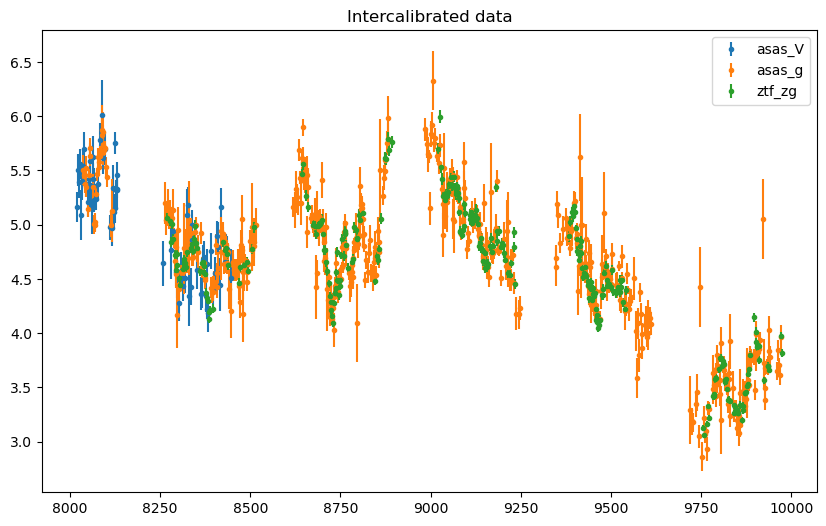

In [30]:
data_cali = np.loadtxt("Mrk335.txt_cali", usecols=(0, 1, 2))
code = np.loadtxt("Mrk335.txt_cali", usecols=(3), dtype=str)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for c in np.unique(code):
    idx = np.where(code == c)[0]
    ax.errorbar(data_cali[idx, 0],  data_cali[idx, 1], yerr=data_cali[idx, 2], ls='none', marker='o', markersize=3, label=c)

ax.legend()
ax.set_title("Intercalibrated data")
plt.show()

<font size=4> There appears a number of outliers. We can discard these outliers as follows. Remove points with a deviation from the reconstruction larger than dev=5sigma and generate a new formatted data file. For example, if the original file name is Mrk335.txt, the new file name will be Mrk335_new.txt. </font>

In [33]:
def load_pycali_data(fname):
  """
  load data from a formatted file
  return a dict
  """
  data = {}
  block = []
  nc = 0
  code = ""
  fp = open(fname)
  for line in fp:
    if line[0] == "#":
      code = line[1:].split()[0]
      nc = int(line[1:].split()[1])
      block.clear()
    else:
      block.append(np.array(line.split(), dtype=float))

    if len(block) == nc:
      data[code] = np.array(block)

  fp.close()
  return data

def remove_outliers(fname, dev=5, doplot=False):
  """
  remove outliers with a deviation of (dev) sigma from the reconstruction

  presume that the file "fname" is in PyCALI format, the previously intercalibrated file is "fname_cali"
               and the reconstruction file is "fname_recon".
  """
  
  if fname == None:
    raise ValueError("need to input a file name!")

  # load data
  data = load_pycali_data(fname)

  # load intercalibrated data and ancillary files
  try:
    cali = np.loadtxt(fname+"_cali", usecols=(0, 1, 2))
    code = np.loadtxt(fname+"_cali", usecols=(3), dtype=str)
  except:
    raise IOError(fname+"_cali error!")
  
  try:
    recon = np.loadtxt(fname+"_recon")
  except:
    raise IOError(fname+"_recon error!")
  
  intp = np.interp(cali[:, 0], recon[:, 0], recon[:, 1])
  err = np.interp(cali[:, 0], recon[:, 0], recon[:, 2])

  # residuals between the calibrated data and reconstruction with a DRW process
  res = (cali[:, 1]-intp)/err

  # now delete bad points with residual > dev sigma
  data_new = {}
  # note here use data.keys() to retain the order of codes
  for c in data.keys():
      idx = np.where((code == c))[0]
      res_code = res[idx]
      idx = np.where(np.abs(res_code)>dev)[0]
      data_new[c] = np.delete(data[c], idx, 0)
  
  path = pathlib.Path(fname)
  fname_new = str(path.parent.joinpath(path.stem+"_new.txt"))
  format(fname_new, data_new)

  # do plotting
  if doplot:
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    plt.plot(cali[:, 0], res, ls='none', marker='o')
    plt.axhline(y=dev, ls='--', color='k')
    plt.axhline(y=-dev, ls='--', color='k')
    ax.set_ylabel("Res")
    ax.set_title("Standarized residuals")
    plt.show()

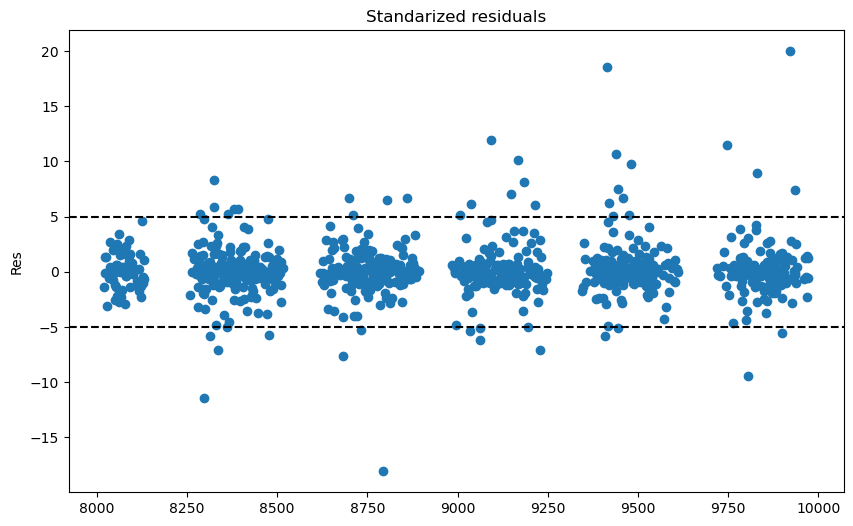

In [34]:
remove_outliers("./Mrk335.txt", dev=5, doplot=True)

<font size=4>**This will generate a new data file named "Mrk335_new.txt". Now redo the intercalibration on new data.**</font>

In [36]:
# rerun cali with Mrk335_new.txt, this will take a while...
os.system("./cali param_new.txt")

=======Input parameters=========
             fname: param_new.txt
             fcont: Mrk335_new.txt
             fline: 
             nmcmc: 10000
   scale_range_low: 0.5
    scale_range_up: 2
   shift_range_low: -1
    shift_range_up: 1
  syserr_range_low: 0
   syserr_range_up: 0.1
errscale_range_low: 0.1
 errscale_range_up: 2
   sigma_range_low: 0.0001
    sigma_range_up: 1
     tau_range_low: 1
      tau_range_up: 10000
       fixed_scale: 0
       fixed_shift: 0
      fixed_syserr: 1
 fixed_error_scale: 1
       fixed_codes: 
  fixed_scalecodes: 
         flag_norm: 1
Mrk335_new.txt
0  ztf_zg   300
1  asas_V   66
2  asas_g   467
  833 points, 3 codes, 1 flags.
# Start diffusive nested sampling.
# Creating level 1 with log likelihood = -1.948175e+04.
# Creating level 2 with log likelihood = -2.405894e+03.
# Creating level 3 with log likelihood = 1.935452e+02.
# Creating level 4 with log likelihood = 6.639159e+02.
# Creating level 5 with log likelihood = 1.234049e+03.
#[0.1%] Savin

0

In [ ]:
data_cali_new = np.loadtxt("Mrk335_new.txt_cali", usecols=(0, 1, 2))
code = np.loadtxt("Mrk335_new.txt_cali", usecols=(3), dtype=str)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for c in np.unique(code):
    idx = np.where(code == c)[0]
    ax.errorbar(data_cali_new[idx, 0],  data_cali_new[idx, 1], yerr=data_cali_new[idx, 2], ls='none', marker='o', markersize=3, label=c)

ax.legend()
ax.set_title("Intercalibrated data")
plt.show()